# CapStone 12
## Deep Learning with TensorFlow and Keras
### EDA

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir="  # empty to avoid XLA GPU

import tensorflow as tf
tf.config.optimizer.set_jit(False)  # disable XLA JIT globally

from tensorflow.keras import layers

gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

x = tf.random.normal([1, 256, 256, 3])
m = tf.keras.Sequential([layers.Conv2D(16, 3, padding="same"), layers.ReLU()])
y = m(x)

print("Conv ran OK, output shape:", y.shape)


Conv ran OK, output shape: (1, 256, 256, 16)


In [2]:
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
print(tf.__version__)
print(tf.sysconfig.get_build_info())

2.16.1
OrderedDict({'cpu_compiler': '/usr/lib/llvm-17/bin/clang', 'cuda_compute_capabilities': ['sm_50', 'sm_60', 'sm_70', 'sm_80', 'compute_90'], 'cuda_version': '12.3', 'cudnn_version': '8', 'is_cuda_build': True, 'is_rocm_build': False, 'is_tensorrt_build': True})


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU available:", tf.config.list_physical_devices("GPU"))

Built with CUDA: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [6]:
data = np.load("DENTAL_1.NPZ")

x_train = data["x_train"]
x_test = data["x_test"]
y_train = data["y_train"]
y_test = data["y_test"]

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print("\nData type:", x_train.dtype)
print("Pixel range (train):", x_train.min(), "to", x_train.max())

x_train shape: (92, 256, 256, 3)
x_test shape: (24, 256, 256, 3)
y_train shape: (92,)
y_test shape: (24,)

Data type: float64
Pixel range (train): 0.0 to 1.0


The dataset is stored in NumPy compressed format and includes:
- Training images
- Testing images
- Corresponding label arrays

**unsupervised denoising problem**

In [7]:
# Dataset
print("Training samples:", x_train.shape[0])
print("Testing samples:", x_test.shape[0])

# dimensions
print("Image shape:", x_train.shape[1:])

Training samples: 92
Testing samples: 24
Image shape: (256, 256, 3)


images are properly formatted, normalized, and suitable for training a convolutional autoencoder.

In [8]:
print("Train pixel mean:", np.mean(x_train))
print("Train pixel std:", np.std(x_train))
print("Train pixel min:", np.min(x_train))
print("Train pixel max:", np.max(x_train))

Train pixel mean: 0.403420922945223
Train pixel std: 0.20964690569163755
Train pixel min: 0.0
Train pixel max: 1.0


Understanding pixel intensity statistics helps confirm normalization and identify potential anomalies.

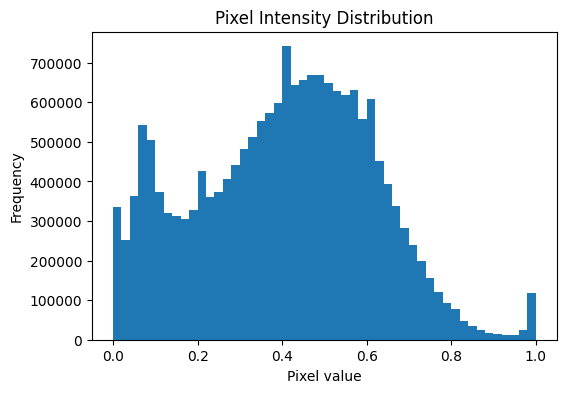

In [9]:
plt.figure(figsize=(6,4))
plt.hist(x_train.flatten(), bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

let's visualize the distribution of pixel values to verify normalization and observe overall contrast patterns across the dataset.

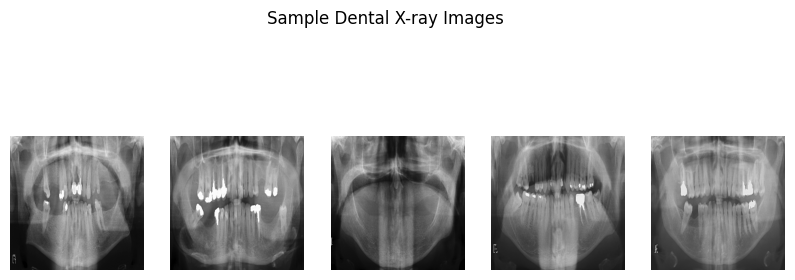

In [10]:
plt.figure(figsize=(10,4))

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_train[i])
    plt.axis("off")

plt.suptitle("Sample Dental X-ray Images")
plt.show()

Visualizing sample images provides insight into image clarity, noise patterns, and structural features.

In [11]:
print("Unique training labels:", np.unique(y_train))

Unique training labels: [0]


Although labels are provided, the dataset contains a single class. This confirms that the task is unsupervised reconstruction rather than classification.

### Process Data

1. Ensure correct dtype as it's standard for deep learning.

In [12]:
x_train_clean = x_train.astype(np.float32)
x_test_clean  = x_test.astype(np.float32)

2. Add Gaussian noise
Noise factor controls how strong the noise is (typical range: 0.05 to 0.3)

In [13]:
noise_factor = 0.15

np.random.seed(42)
x_train_noisy = x_train_clean + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_clean.shape)
x_test_noisy  = x_test_clean  + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_clean.shape)

3. Clip to keep values normalized between 0 and 1

In [14]:
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy  = np.clip(x_test_noisy, 0.0, 1.0)

print("Clean Train Range:", x_train_clean.min(), "to", x_train_clean.max())
print("Noisy Train Range:", x_train_noisy.min(), "to", x_train_noisy.max())

Clean Train Range: 0.0 to 1.0
Noisy Train Range: 0.0 to 1.0


4. Visualize PRE vs POST processing

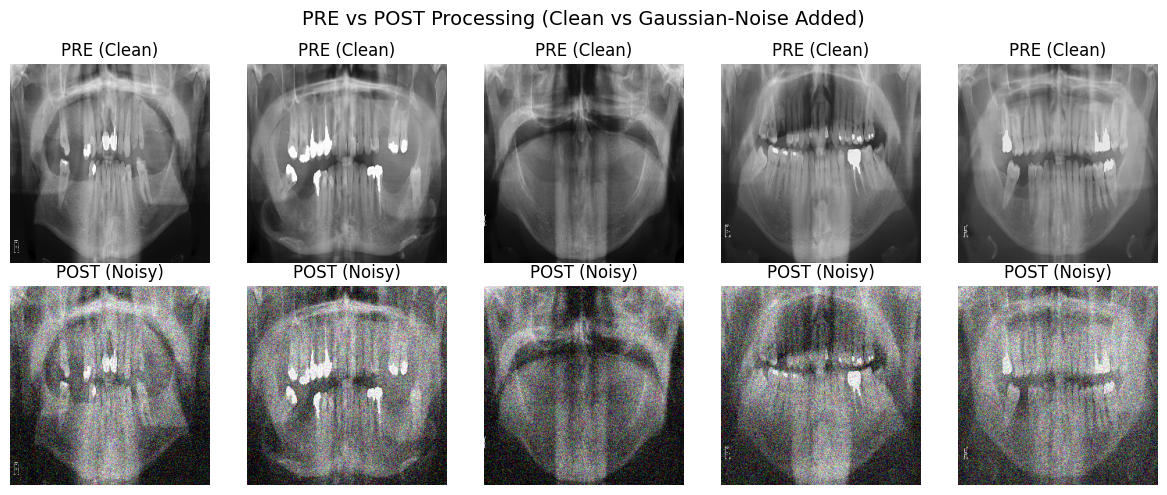

In [15]:
n = 5  # num of examples
plt.figure(figsize=(12, 5))

for i in range(n):
    # PRE (Clean)
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train_clean[i])
    plt.title("PRE (Clean)")
    plt.axis("off")

    # POST (Noisy)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_noisy[i])
    plt.title("POST (Noisy)")
    plt.axis("off")

plt.suptitle("PRE vs POST Processing (Clean vs Gaussian-Noise Added)", fontsize=14)
plt.tight_layout()
plt.show()

The POST images show added Gaussian noise, resulting in a grainy appearance and reduced visual clarity compared to the clean PRE images. But the key structural details remain visible, making the data appropriate for training a denoising autoencoder.

### Build and Train Autoencoder using convolutional (Encoder) and transposed convolutional layers (Decoder)

- **Encoder (Conv2D)** layers to compress the image into a smaller feature representation
- **Decoder (Conv2DTranspose)** layers to reconstruct the image back to its original resolution

The goal is to minimize reconstruction error (so let's use **MSE loss**) so the output becomes a “cleaned” version of the noisy input.

In [16]:
input_shape = x_train_noisy.shape[1:]  #(256, 256, 3)

def build_denoising_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3,3), strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(64, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Bottleneck
    x = layers.Conv2D(256, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Decoder
    x = layers.Conv2DTranspose(128, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(32, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(16, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Reconstruction layer
    outputs = layers.Conv2D(3, (3,3), activation="sigmoid", padding="same")(x)

    return Model(inputs, outputs, name="Denoising_Autoencoder")

autoencoder = build_denoising_autoencoder(input_shape)
autoencoder.summary()

Model: "Denoising_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 783,651 (2.99 MB)

 Trainable params: 782,211 (2.98 MB)

 Non-trainable params: 1,440 (5.62 KB)

This architecture shows a symmetric encoder–decoder structure where convolutional layers progressively reduce spatial dimensions while increasing feature depth, followed by transposed convolutional layers that reconstruct the image back to its original resolution. With approximately 783K parameters. The model maintains a moderate complexity suitable for learning meaningful representations for dental X-ray denoising.

#### Compile & Train

In [18]:
# Compile
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    jit_compile=False,  # <- important
)

# Callbacks
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# Train
history = autoencoder.fit(
    x_train_noisy, x_train_clean,
    epochs=30,
    batch_size=1, #was 8, but 1 is better for small datasets
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    shuffle=True
)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0165 - val_loss: 0.0482 - learning_rate: 0.0010
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0095 - val_loss: 0.0364 - learning_rate: 0.0010
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0077 - val_loss: 0.0249 - learning_rate: 0.0010
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0074 - val_loss: 0.0220 - learning_rate: 0.0010
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0063 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0057 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0050 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0054 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 9/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0051 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 10/30
73/73 ━

Plot for training and validation loss to verify learning stability and check for overfitting.

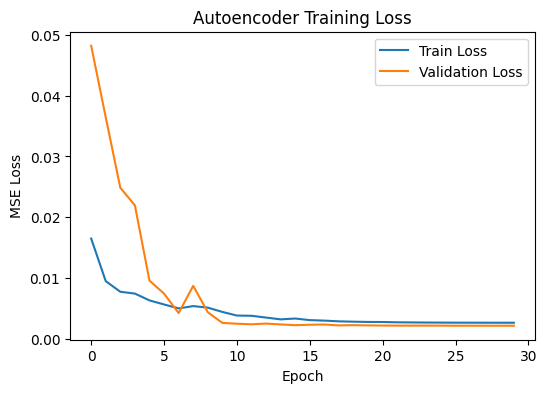

In [19]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

#### Reconstruct and Visualize (noisy -> Denoised -> Clean)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


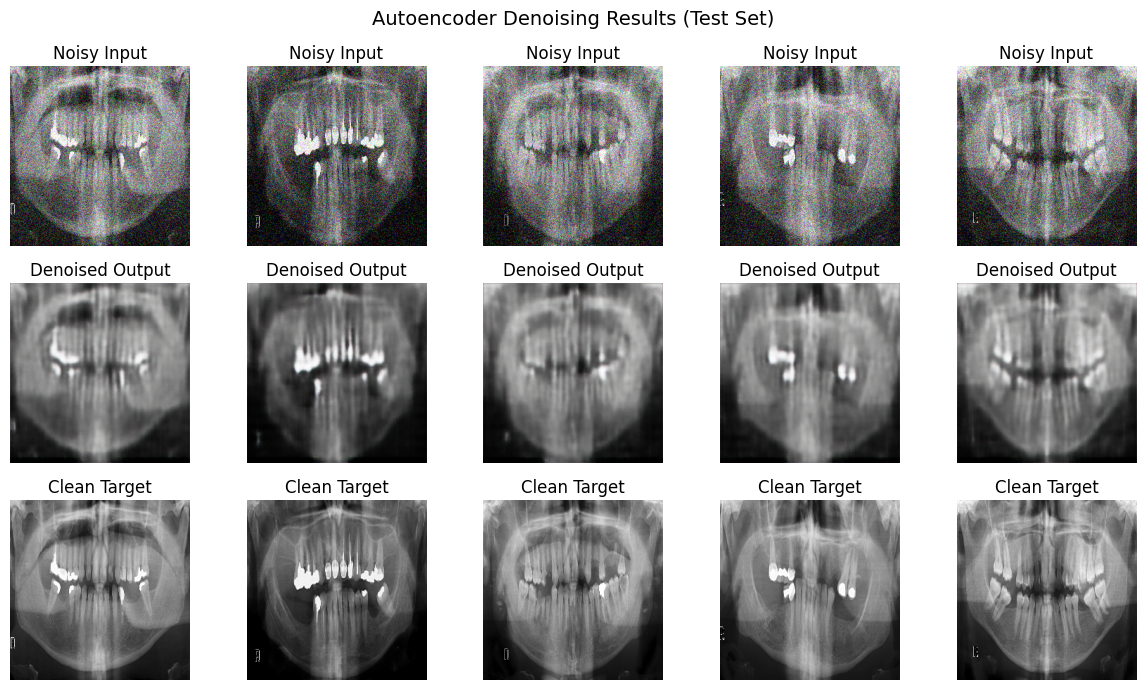

In [20]:
# Predict (denoise) on noisy test images
x_test_denoised = autoencoder.predict(x_test_noisy)

# Visualize results
n = 5  # number of test images to display
plt.figure(figsize=(12, 7))

for i in range(n):
    # Noisy input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy Input")
    plt.axis("off")

    # Denoised output
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_denoised[i])
    plt.title("Denoised Output")
    plt.axis("off")

    # Clean ground truth
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test_clean[i])
    plt.title("Clean Target")
    plt.axis("off")

plt.suptitle("Autoencoder Denoising Results (Test Set)", fontsize=14)
plt.tight_layout()
plt.show()

The autoencoder successfully reduces Gaussian noise, producing smoother images compared to the noisy inputs. But some fine structural details appear slightly blurred, indicating something between noise removal and sharpness preservation.

### Learning Outcomes and Challenges

Through this project I gained a much clearer understanding of how deep learning can be applied to image-based problems especially denoising medical images using convolutional autoencoders. I learned how to work with compressed NumPy datasets, explore image data in a meaningful way, and apply preprocessing steps like adding Gaussian noise and maintaining proper normalization so the model could learn effectively.

One of the biggest takeaways for me was building intuition around encoder–decoder architectures and seeing how convolutional layers compress image information while transposed convolutional layers reconstruct it back to the original resolution. Visualizing the clean, noisy, and reconstructed images side by side also helped me better understand what the model was actually learning rather than relying only on loss values.

There was definitely a learning curve throughout this process. I faced challenges understanding image tensor shapes, deciding on an appropriate noise level, designing a reasonable autoencoder architecture, and working through training-related issues. However, navigating these challenges helped me become more comfortable debugging deep learning workflows, interpreting model outputs, and connecting the concepts I am learning with hands-on implementation.

# SECOND UPLOAD 
During my initial training runs, I noticed that my GPU was not being used as expected, which led me to investigate the environment setup. After checking device availability and reviewing error logs, I found that TensorFlow was attempting to use the XLA GPU backend, causing cuDNN initialization issues. Disabling XLA GPU execution before importing TensorFlow resolved the problem and allowed the model to run properly using the standard CUDA runtime.

Once GPU execution was working, I observed that the Autoencoder Training Loss curve changed compared to earlier runs. The loss decreased more smoothly and converged faster, which suggested more stable training and improved efficiency. This was interesting to see because it highlighted how hardware acceleration and environment configuration can impact not just training speed, but also the overall learning behavior of the model.

### BONUS — Train a GAN to Generate “Fake” Dental X-rays (DCGAN)

In this bonus section, we train a Deep Convolutional GAN (DCGAN) to generate synthetic dental X-ray images.

A GAN has two neural networks:
- **Generator (G):** takes random noise and tries to generate realistic X-ray images.
- **Discriminator (D):** tries to distinguish real X-rays from fake ones.

They are trained in opposition:
- The discriminator learns to get better at classification (real vs fake).
- The generator learns to fool the discriminator by producing more realistic images.

We will:
1. Prepare images for GAN training (scale to **[-1, 1]**).
2. Build the Generator and Discriminator using convolutional layers.
3. Train using a custom training loop.
4. Visualize generated samples during training.

In [21]:
# GANs typically train better on [-1, 1] with tanh output
# We'll convert to grayscale to simplify (dental X-rays are effectively grayscale anyway)

x_gan = x_train_clean  # (92, 256, 256, 3) in [0,1]

# Convert RGB -> grayscale: shape becomes (N, 256, 256, 1)
x_gan_gray = tf.image.rgb_to_grayscale(x_gan).numpy().astype(np.float32)

# Scale [0,1] -> [-1,1]
x_gan_gray = (x_gan_gray * 2.0) - 1.0

print("GAN training data shape:", x_gan_gray.shape)
print("Range:", x_gan_gray.min(), "to", x_gan_gray.max())

# Create tf.data pipeline
BUFFER_SIZE = x_gan_gray.shape[0]
BATCH_SIZE = 8

train_ds = (
    tf.data.Dataset.from_tensor_slices(x_gan_gray)
    .shuffle(BUFFER_SIZE, seed=42)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

GAN training data shape: (92, 256, 256, 1)
Range: -1.0 to 0.99979997


### Build the Generator

The generator transforms a random latent vector (noise) into a 256×256 grayscale image.
We use Dense + Reshape, followed by several Conv2DTranspose layers to upsample to full resolution.
The final layer uses **tanh**, matching our image scaling to **[-1, 1]**.

In [22]:
LATENT_DIM = 128
IMG_H, IMG_W, IMG_C = 256, 256, 1

def make_generator(latent_dim=LATENT_DIM):
    model = tf.keras.Sequential(name="Generator")

    model.add(layers.Input(shape=(latent_dim,)))
    model.add(layers.Dense(16 * 16 * 256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((16, 16, 256)))  # 16x16

    # Upsample: 16 -> 32 -> 64 -> 128 -> 256
    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, 4, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(32, 4, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(16, 4, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Final: 256x256x1, tanh for [-1,1]
    model.add(layers.Conv2DTranspose(1, 3, strides=1, padding="same", activation="tanh"))

    return model

generator = make_generator()
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 65536)          │     8,388,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 65536)          │       262,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 128, 128, 32)   │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 256, 256, 16)   │         8,192 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 256, 256, 1)    │           145 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,348,177 (35.66 MB)

 Trainable params: 9,216,625 (35.16 MB)

 Non-trainable params: 131,552 (513.88 KB)

### Build the Discriminator

The discriminator takes a 256×256 grayscale image and predicts whether it is:
- **Real (from the dataset)** or
- **Fake (generated by the generator)**

We use Conv2D layers with downsampling + LeakyReLU, ending in a single sigmoid probability.

In [23]:
def make_discriminator():
    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Input(shape=(IMG_H, IMG_W, IMG_C)))

    model.add(layers.Conv2D(32, 4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, 4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, 4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, 4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))

    return model

discriminator = make_discriminator()
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        65,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 754,657 (2.88 MB)

 Trainable params: 754,657 (2.88 MB)

 Non-trainable params: 0 (0.00 B)

### GAN Training Setup

We train using Binary Cross-Entropy:
- Discriminator loss: correctly classify real as 1 and fake as 0
- Generator loss: fool the discriminator into predicting fake as real (1)

We use a custom training loop to alternate:
1. Update discriminator
2. Update generator

In [24]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

gen_opt = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]

    # Create noise for generator
    noise = tf.random.normal([batch_size, LATENT_DIM])

    # Labels
    real_labels = tf.ones((batch_size, 1))
    fake_labels = tf.zeros((batch_size, 1))

    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        fake_images = generator(noise, training=True)

        real_pred = discriminator(real_images, training=True)
        fake_pred = discriminator(fake_images, training=True)

        # Discriminator wants: real->1, fake->0
        d_loss_real = bce(real_labels, real_pred)
        d_loss_fake = bce(fake_labels, fake_pred)
        d_loss = d_loss_real + d_loss_fake

        # Generator wants discriminator to think fake is real -> 1
        g_loss = bce(real_labels, fake_pred)

    d_grads = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    g_grads = gen_tape.gradient(g_loss, generator.trainable_variables)

    disc_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    gen_opt.apply_gradients(zip(g_grads, generator.trainable_variables))

    return d_loss, g_loss

### Train the GAN & Visualize Generated Samples

Periodically generate a small grid of fake X-rays so it's possible to visually monitor progress.
Since the generator outputs are in [-1, 1], we can rescale them back to [0, 1] for display.

2026-02-27 09:57:19.990603: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1/200 | D Loss: 0.5842 | G Loss: 2.3862


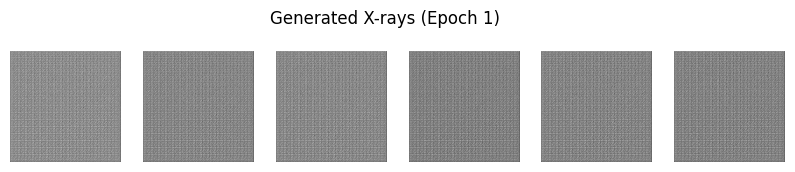

Epoch 25/200 | D Loss: 0.3328 | G Loss: 3.0955


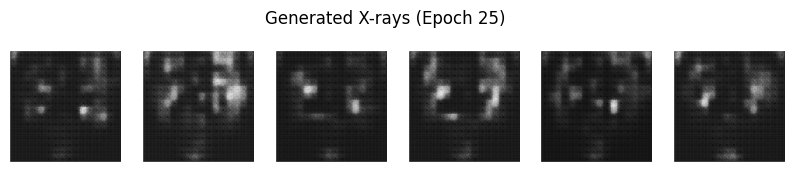

Epoch 50/200 | D Loss: 0.6686 | G Loss: 2.3506


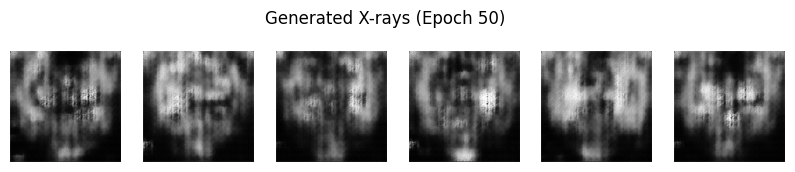

Epoch 75/200 | D Loss: 0.6454 | G Loss: 1.5993


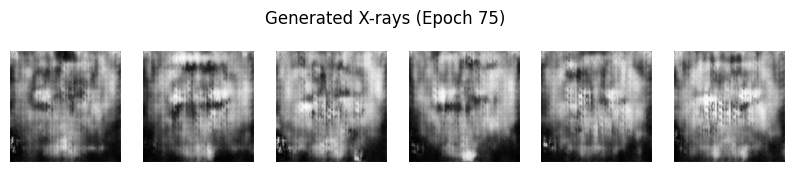

Epoch 100/200 | D Loss: 0.6936 | G Loss: 1.6260


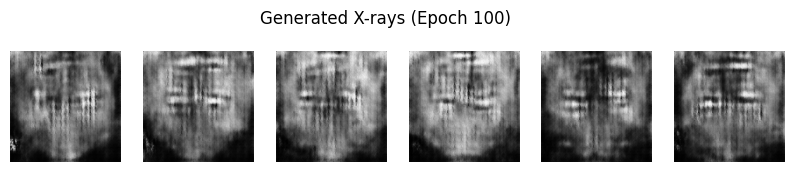

Epoch 125/200 | D Loss: 0.4181 | G Loss: 3.0870


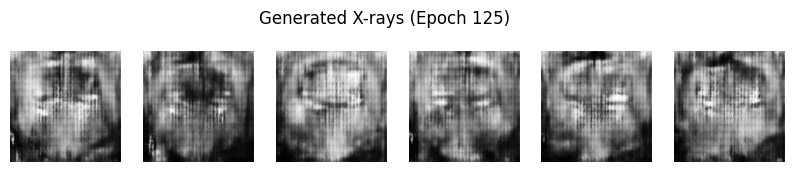

Epoch 150/200 | D Loss: 0.4415 | G Loss: 2.2514


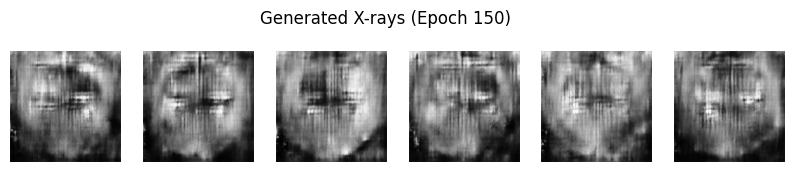

Epoch 175/200 | D Loss: 0.2954 | G Loss: 2.8911


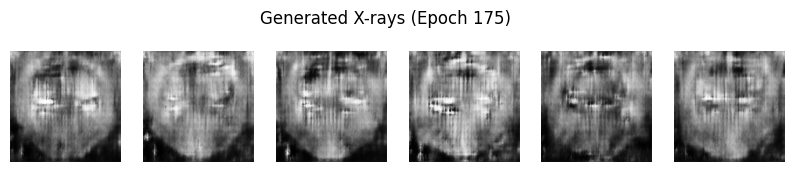

Epoch 200/200 | D Loss: 0.3804 | G Loss: 3.6012


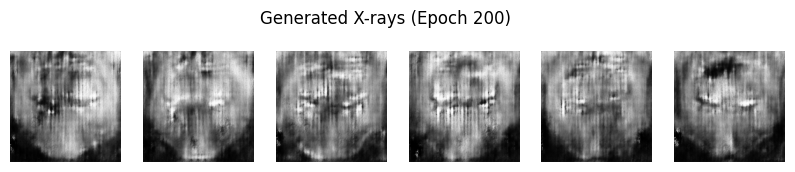

In [25]:
def show_generated_images(epoch, n=6):
    noise = tf.random.normal([n, LATENT_DIM])
    fake = generator(noise, training=False)

    # Rescale [-1,1] -> [0,1]
    fake = (fake + 1.0) / 2.0

    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(fake[i, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Generated X-rays (Epoch {epoch})")
    plt.show()

EPOCHS = 200  # with small data, more epochs helps; you can also try 100 first

for epoch in range(1, EPOCHS + 1):
    d_losses, g_losses = [], []

    for real_batch in train_ds:
        d_loss, g_loss = train_step(real_batch)
        d_losses.append(d_loss.numpy())
        g_losses.append(g_loss.numpy())

    if epoch % 25 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{EPOCHS} | D Loss: {np.mean(d_losses):.4f} | G Loss: {np.mean(g_losses):.4f}")
        show_generated_images(epoch)